In [202]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from util import *
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import time
from joblib import Memory
from scipy.ndimage.measurements import label

%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/Users/yuri/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['box']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [118]:
memory = Memory(cachedir='cache')

In [83]:
def traverse_train_dataset(base_dir, dirs):
    return np.concatenate([[f for f in glob.glob('%s/%s/*.png' % (base_dir, d))] for d in dirs])


In [84]:
vehicle_files = traverse_train_dataset('vehicles', ['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted'])
nonvehicle_files = traverse_train_dataset('non-vehicles', ['Extras', 'GTI'])

In [85]:
data_look(vehicle_files, nonvehicle_files)

{'data_type': dtype('float32'),
 'image_shape': (64, 64, 3),
 'n_cars': 8792,
 'n_notcars': 8968}

In [128]:
#sample_size = np.min([len(vehicle_files), len(nonvehicle_files)])
#cars = vehicle_files[0:sample_size]
#notcars = nonvehicle_files[0:sample_size]

cars = vehicle_files
notcars = nonvehicle_files

In [129]:
conv = cv2.COLOR_RGB2YCrCb
orient = 9
hist_bins = 32
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size=(32, 32)

In [133]:
@memory.cache
def train_svc(scaled_X, y):
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    svc = LinearSVC()

    svc.fit(X_train, y_train)
    
    return svc, svc.score(X_test, y_test)

t = time.time()

car_features = extract_features(cars,
                                conv=conv,
                                orient=orient, 
                                spatial_size=spatial_size,
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,
                                hist_bins=hist_bins,
                                hog_feat=True,
                                spatial_feat=True,
                                hist_feat=True)

notcar_features = extract_features(notcars,
                                   conv=conv,                                   
                                   orient=orient, 
                                   spatial_size=spatial_size,
                                   pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel,
                                   hist_bins=hist_bins,
                                   hog_feat=True,
                                   spatial_feat=True,
                                   hist_feat=True)

t2 = time.time()
print(round(t2 - t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64) 
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

t = time.time()
   
svc, svc_acc = train_svc(scaled_X, y)
    
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc_acc, 4))


3.37 Seconds to extract HOG features...


________________________________________________________________________________
[Memory] Calling __main__--Users-yuri-work-udacity-cv-CarND-Vehicle-Detection-__ipython-input__.train_svc...
train_svc(array([[ 1.37974 , ..., -0.765602],
       ..., 
       [-0.615062, ...,  0.116964]]), 
array([ 1., ...,  0.]))
_______________________________________________________train_svc - 12.8s, 0.2min
13.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9876


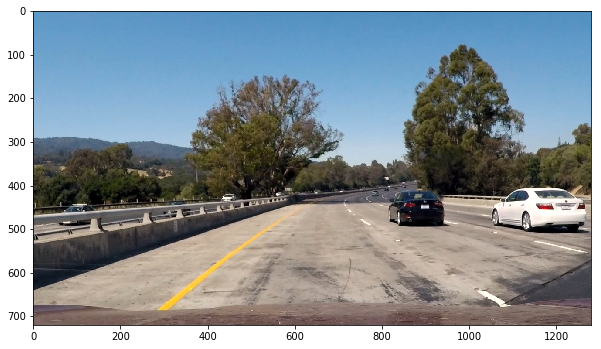

In [134]:
test_images = [mpimg.imread(f) for f in glob.glob('test_images/*.jpg')]
plt.imshow(test_images[0])

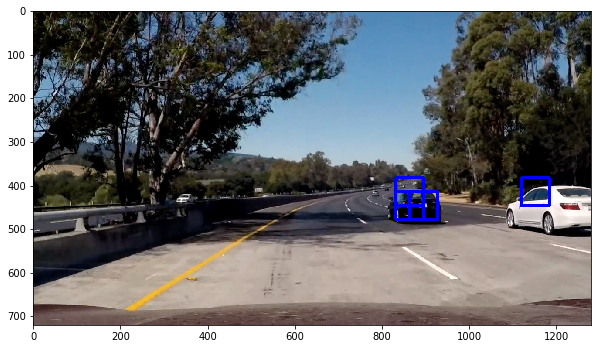

In [237]:
test_image = test_images[4]

car_boxes = find_cars(test_image,
                     conv=conv,                     
                     ystart=350,
                     ystop=650,
                     scale=1,
                     svc=svc,
                     X_scaler=X_scaler,
                     orient=orient,
                     pix_per_cell=pix_per_cell,
                     cell_per_block=cell_per_block,
                     spatial_size=spatial_size,
                     hist_bins=hist_bins)

plt.imshow(visualize_found_cars(test_image, car_boxes))

In [376]:
def find_cars_multi(image):
    car_boxes = []
    for i in range(0, 7):
        scale = 0.5 + 0.25 * i
        scale_boxes = find_cars(image,
                             conv=conv,                     
                             ystart=400,
                             ystop=650,
                             scale=scale,
                             svc=svc,
                             X_scaler=X_scaler,
                             orient=orient,
                             pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             spatial_size=spatial_size,
                             hist_bins=hist_bins)
        
        if (len(scale_boxes) > 0):
            # Fix np.concatenate() ValueError: all the input arrays must have same number of dimensions
            car_boxes.append(scale_boxes)

    # Fix ValueError: need at least one array to concatenate
    return np.concatenate(car_boxes) if len(car_boxes) > 0 else []

test_image = test_images[4]
car_boxes = find_cars_multi(test_image)

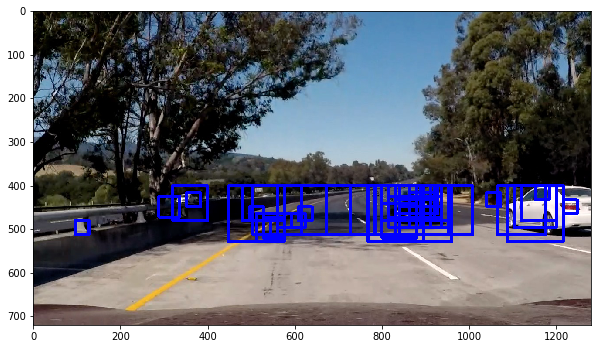

In [377]:
plt.imshow(visualize_found_cars(test_image, car_boxes))

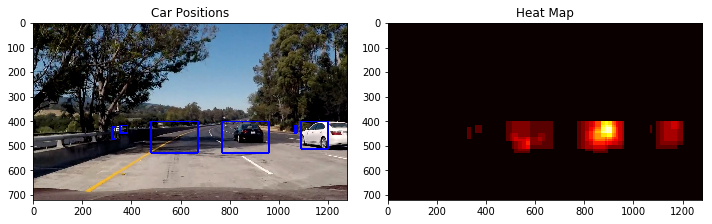

In [378]:
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, car_boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [379]:
def get_heatmap(image):
    car_boxes = find_cars_multi(image)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, car_boxes)
    
    return heat

def annotate_frame(image, thresh=0):
    heat = get_heatmap(image)
    
    if thresh > 0:
        heat = apply_threshold(heat, thresh)
    
    labels = label(heat)
    
    return draw_labeled_bboxes(np.copy(image), labels)

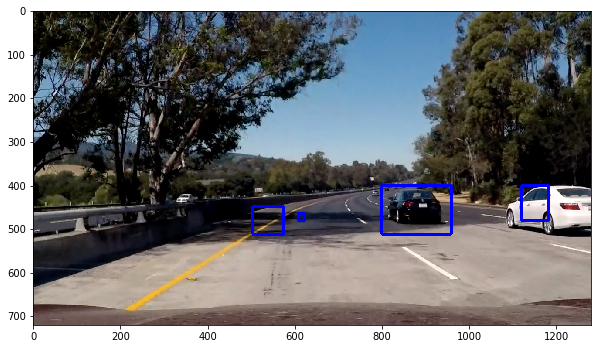

In [381]:
plt.imshow(annotate_frame(test_images[4], 3))

In [341]:
class FrameState():
    history_size = None
    thresh = None
    history_boxes = []
    
    def __init__(self, history_size=1, thresh=0):
        self.history_boxes = []
        self.history_size = history_size
        self.thresh = thresh
    
    def __call__(self, image):
        frame_boxes = find_cars_multi(image)
        self.history_boxes.append(frame_boxes)
        
        if len(self.history_boxes) > self.history_size:
            del(self.history_boxes[0])
        
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat, np.concatenate(self.history_boxes))
    
        if self.thresh > 0:
            heat = apply_threshold(heat, self.thresh)    
    
        labels = label(heat)
        
        return np.clip(heat, 0, 255)
        #return draw_labeled_bboxes(np.copy(image), labels)
        #return draw_labeled_bboxes(np.clip(heat, 0, 255), labels)


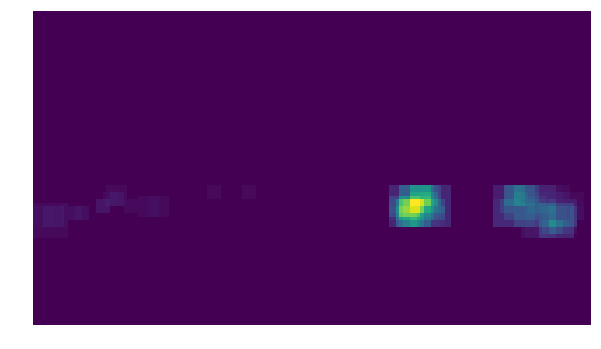

In [343]:
from IPython.display import clear_output

state = FrameState(8, 1)

vid = cv2.VideoCapture("test_video.mp4")

try:
    while(True):
        ret, frame = vid.read()
        if not ret:
            vid.release()
            break
            
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axis('off')

        result_frame = state(frame)
        
        plt.imshow(result_frame)       
        
        show()

        clear_output(wait=True)
        
except KeyboardInterrupt:
    vid.release()

In [303]:
from moviepy.editor import VideoFileClip

test_output = 'project_video_result.mp4'
clip = VideoFileClip('project_video.mp4')
fl_clip = clip.fl_image(annotate_frame)
%time fl_clip.write_videofile(test_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


  0%|          | 4/1261 [00:11<1:00:54,  2.91s/it]

KeyboardInterrupt: 